# Lab 4

## Authors:
- Francisco Roh
- Bryan Calisto

### Conclusion
The generated sentences didn't make much sense, but this conclusion is influenced in part by the lack of stopwords, which contribute to some meaning and make the sentences look natural. Assuming there's stopwords, the texts would look better than what was seen in the pure word2vec, non-cnn version. As a downside, a few words were duplicated, one following the other, even though the predicted word was sampled from a multinomial distribution based on the topk 100 highest probabilities of the model's softmax results. Finally, we predicted the sentences token using the topk 1000 highest probabilities and the duplicates mostly dissapeared.

In [1]:
import torch
import numpy as np
from tqdm.auto import tqdm
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Load and preprocess data (using the whole book)

In [3]:
nltk.download('stopwords')
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itsme007\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
text = open('./gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()

In [5]:
def split_tokens(text, stem=False):
    tokens = tokenizer.tokenize(text)

    if stem:
        tokens = [ss.stem(w) for w in tokens if w not in sw]
    else:
      tokens = [w for w in tokens if w not in sw]

    return tokens


In [6]:
tokens = split_tokens(text)
print('len tokens:', len(tokens))
print(tokens[:10])

len tokens: 70255
['gabriel', 'garcía', 'márquez', 'cien', 'años', 'soledad', 'editado', 'ediciones', 'cueva', 'j']


In [8]:
counts = Counter(tokens)
print(counts.most_common(10))

[('aureliano', 794), ('úrsula', 514), ('arcadio', 480), ('casa', 463), ('josé', 424), ('buendía', 406), ('años', 357), ('coronel', 312), ('amaranta', 310), ('segundo', 308)]


In [9]:
counts_more_than_1 = {k:v for k,v in counts.items() if v > 1}
print('len tokens with more than 1 ocurrences:', len(counts_more_than_1))

len tokens with more than 1 ocurrences: 7406


In [10]:
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v:k for k,v in itot.items()}
print('len vocab', len(vocab))
print(vocab[:20])

len vocab 7406
['gabriel', 'garcía', 'márquez', 'cien', 'años', 'soledad', 'ediciones', 'cueva', 'j', 'maría', 'después', 'frente', 'pelotón', 'fusilamiento', 'coronel', 'aureliano', 'buendía', 'recordar', 'aquella', 'tarde']


In [11]:
tokens_more_than_1 = [w for w in tokens if w in vocab] # tokens with more than one ocurrence, picked in the order they appear, including duplicates
print('len tokens_more_than_1:', len(tokens_more_than_1))
print('len tokens_more_than_1 without duplicates (same as vocab, as expected)', len(list(set(tokens_more_than_1))))
print(tokens_more_than_1[:20])

len tokens_more_than_1: 61989
len tokens_more_than_1 without duplicates (same as vocab, as expected) 7406
['gabriel', 'garcía', 'márquez', 'cien', 'años', 'soledad', 'ediciones', 'cueva', 'j', 'garcía', 'maría', 'cien', 'años', 'soledad', 'gabriel', 'garcía', 'márquez', 'años', 'después', 'frente']


In [11]:
def create_sequences(tokenized_text, seq_length):
    sequences = []
    for i in range(len(tokenized_text) - seq_length):
        seq = tokenized_text[i:i + seq_length]
        target = tokenized_text[i + seq_length]
        sequences.append((seq, target))
    return sequences


sequences = create_sequences([ttoi[tok] for tok in tokens_more_than_1], seq_length=10)
print(sequences[:20])

[([0, 1, 2, 3, 4, 5, 6, 7, 8, 1], 9), ([1, 2, 3, 4, 5, 6, 7, 8, 1, 9], 3), ([2, 3, 4, 5, 6, 7, 8, 1, 9, 3], 4), ([3, 4, 5, 6, 7, 8, 1, 9, 3, 4], 5), ([4, 5, 6, 7, 8, 1, 9, 3, 4, 5], 0), ([5, 6, 7, 8, 1, 9, 3, 4, 5, 0], 1), ([6, 7, 8, 1, 9, 3, 4, 5, 0, 1], 2), ([7, 8, 1, 9, 3, 4, 5, 0, 1, 2], 4), ([8, 1, 9, 3, 4, 5, 0, 1, 2, 4], 10), ([1, 9, 3, 4, 5, 0, 1, 2, 4, 10], 11), ([9, 3, 4, 5, 0, 1, 2, 4, 10, 11], 12), ([3, 4, 5, 0, 1, 2, 4, 10, 11, 12], 13), ([4, 5, 0, 1, 2, 4, 10, 11, 12, 13], 14), ([5, 0, 1, 2, 4, 10, 11, 12, 13, 14], 15), ([0, 1, 2, 4, 10, 11, 12, 13, 14, 15], 16), ([1, 2, 4, 10, 11, 12, 13, 14, 15, 16], 17), ([2, 4, 10, 11, 12, 13, 14, 15, 16, 17], 18), ([4, 10, 11, 12, 13, 14, 15, 16, 17, 18], 19), ([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 20), ([11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 21)]


In [12]:
class TextDataset(Dataset):
  def __init__(self, sequences):
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    seq, target = self.sequences[idx]
    return torch.tensor(seq), torch.tensor(target)

def seq_to_words(seq):
  return [itot[tok_i] for tok_i in seq]

In [13]:
dataset = TextDataset(sequences)

for i in range(3):
  print('SAMPLE', i)
  sample_x, sample_y = dataset[i]

  print(f'sample_x:\n\t{sample_x}\n\tshape: {sample_x.shape}\n\t{seq_to_words(sample_x.tolist())}')
  print()
  print(f'sample_y:\n\t{sample_y}\n\t{itot[sample_y.item()]}')

SAMPLE 0
sample_x:
	tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 1])
	shape: torch.Size([10])
	['gabriel', 'garcía', 'márquez', 'cien', 'años', 'soledad', 'ediciones', 'cueva', 'j', 'garcía']

sample_y:
	9
	maría
SAMPLE 1
sample_x:
	tensor([1, 2, 3, 4, 5, 6, 7, 8, 1, 9])
	shape: torch.Size([10])
	['garcía', 'márquez', 'cien', 'años', 'soledad', 'ediciones', 'cueva', 'j', 'garcía', 'maría']

sample_y:
	3
	cien
SAMPLE 2
sample_x:
	tensor([2, 3, 4, 5, 6, 7, 8, 1, 9, 3])
	shape: torch.Size([10])
	['márquez', 'cien', 'años', 'soledad', 'ediciones', 'cueva', 'j', 'garcía', 'maría', 'cien']

sample_y:
	4
	años


### Define and train the convolutional neural network (CNN)

In [14]:
class CNN(nn.Module):
    def __init__(self, vocab_size, n_embeddings, output_dim, dropout=0.5):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, n_embeddings)

        self.conv1 = nn.Conv1d(in_channels=n_embeddings,
                      out_channels=64,
                      kernel_size=3, padding=1)

        self.conv2 = nn.Conv1d(in_channels=64,
                      out_channels=32,
                      kernel_size=3, padding=1)

        self.fc = nn.Linear(32, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.to(torch.long)
        out = self.embedding(x)

        # Reshape for conv1d: transpose to [batch_size, n_embeddings, seq_length]
        out = out.permute(0, 2, 1)

        out = self.conv1(out)
        out = self.conv2(out)

        out = F.max_pool1d(out, out.shape[2]).squeeze(2)

        out = self.dropout(out)

        logits = self.fc(out)

        return logits

CNN(
  (embedding): Embedding(7406, 100)
  (conv1): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=32, out_features=7406, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


  0%|          | 0/100 [00:00<?, ?it/s]

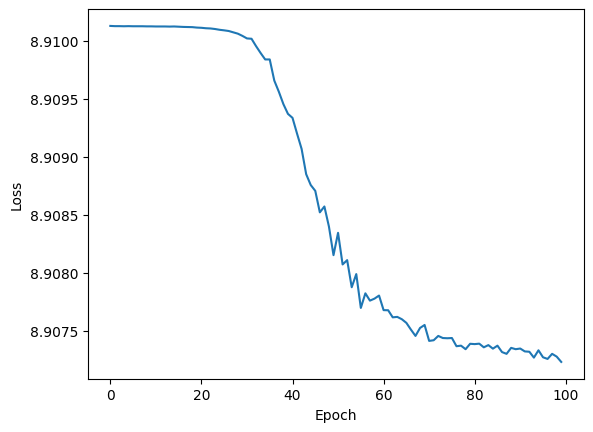

In [31]:
N_EMBEDDINGS = 100
N_TOKENS = len(vocab)
model = CNN(N_TOKENS, N_EMBEDDINGS, N_TOKENS)
print(model)
model = model.to(device)


LR = 3e-4
EPOCHS = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


BATCH_SIZE = 65536 # Take advantage of GPU parallelism as there's enough memory
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

# Train
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for sequence_words, next_word in dataloader:
        sequence_words, next_word = sequence_words.to(device), next_word.to(device)
        next_word = next_word.to(torch.float)
        sequence_words = sequence_words.to(torch.float)
        optimizer.zero_grad()
        logits = model(sequence_words)
        preds = F.softmax(logits, dim=1)
        loss = loss_fn(preds, next_word.long())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

plt.plot(running_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### Explore the generated embedding looking into the word distances/similarity

In [32]:
wordvecs = model.fc.weight.cpu().detach().numpy()
print('wordvecs shape:', wordvecs.shape, ', i.e. (tokens_more_than_1 size, n_embeddings)')
print(wordvecs)

wordvecs shape: (7406, 32) , i.e. (tokens_more_than_1 size, n_embeddings)
[[-0.15631053 -0.09388111  0.02382176 ...  0.06830794  0.02461547
   0.18333916]
 [ 0.14290419  0.19757889  0.09537861 ...  0.03294746 -0.04505607
  -0.05169737]
 [ 0.12570749  0.18497527  0.03025965 ... -0.001939   -0.08813806
  -0.1302969 ]
 ...
 [-0.13804394  0.10761523  0.06173731 ...  0.07184434 -0.10344772
  -0.08319366]
 [-0.18051118 -0.1790618   0.13532571 ...  0.02113642  0.11706142
  -0.14530358]
 [-0.06149564 -0.10046851  0.12226793 ... -0.01198369 -0.00552149
  -0.05729938]]


In [33]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    ind = [ttoi[tokens_more_than_1[i]] for i in ind]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']
for word in tokens_test:
    print(word, [(t[1], t[2]) for t in get_k_similar_words(word, dmat, k=10)], "\n") # print word and distance respective to the first word

aureliano [('reveló', 0.8974792496470198), ('catalejo', 0.7022560277435268), ('deprimido', 1.1029533003883907), ('arcadio', 0.9314220022557912), ('camisas', 1.050865323490463), ('maría', 1.060646636043927), ('contemplando', 0.936967196663556), ('prácticas', 0.8960037190938864), ('tocó', 1.0803423703381865), ('influencia', 1.3466652597651683)] 

coronel [('hora', 0.7965471900164975), ('vez', 0.6570554930897925), ('huerta', 0.935648012691478), ('fin', 0.9204629390473633), ('hacía', 1.0353549308530705), ('solo', 1.06719543377389), ('mundo', 0.7792741083596145), ('tiempo', 0.5120950550357746), ('conjeturas', 1.2025065891864628), ('galeón', 0.9363013354610619)] 

macondo [('hierros', 1.220491637113038), ('buendía', 0.671085789676716), ('perder', 1.1274524019465888), ('andar', 0.9105256044682639), ('mantenía', 0.9920792690122153), ('simplicidad', 1.0938118858406), ('cama', 1.1352056885131425), ('cada', 0.8311820978830269), ('buendía', 0.671085789676716), ('sembrado', 1.0897825217937631)] 

c

### Generate some sentences

In [38]:
# Based on an initial text, it predicts the next token. Then, it reformulates a new sequence moving one step forward through the sequence (including the newly generated token) and uses it to predict the next token. It repeats until the
# sentence is formed by 'max_length' tokens.
def generate_sentence(net, initial_text, ttoi, itot, max_length):
    sentence = []

    net.eval()
    with torch.no_grad():
        seq = initial_text.lower().split()
        seq_len = len(seq)
        sentence.extend(seq)
        seq = [ttoi[w] for w in seq]
        seq = torch.tensor(seq)
        seq = seq.to(device)
        seq = seq.unsqueeze(0) # convert into batch of size=1

        for i in range(max_length):
          logits = net(seq.to(torch.float))
          probs = F.softmax(logits, dim=1).squeeze(0)
          top_probs, top_indices = torch.topk(probs, k=1000)
          pred = torch.multinomial(top_probs, num_samples=1, replacement=True)
          pred_as_text = itot[pred.item()]
          sentence.append(pred_as_text)
          seq = sentence[i:i + seq_len + 1]
          seq = [ttoi[w] for w in seq]
          seq = torch.tensor(seq)
          seq = seq.to(device)
          seq = seq.unsqueeze(0)

    return ' '.join(sentence)


test_sequences = [
    'arrastrando dos lingotes',
    'familia gitanos locos',
    'casas grandes ciudad',
    'gabriel garcía márquez',
    'primero llevaron gitano'
]

for seq in test_sequences:
    print(generate_sentence(model, seq, ttoi, itot, max_length=10))


arrastrando dos lingotes hacia castaño mitad macondo virtudes privaciones quemaduras palmo plomo partida
familia gitanos locos puesto pregonaba anunciaba xv además mulo doméstico anteriores blancas decrépito
casas grandes ciudad olán hielo pensó moverse pronto establecer partes respuesta entonces piedras
gabriel garcía márquez sonrió investigaciones cinco naranja sencillo xv cien aquella padre gabriel
primero llevaron gitano parecido gritó mientras reunió perdió barba testimonio desapareció complicadas sentó
